In [ ]:
%pip install -Uq mlflow==2.13.2 sagemaker-mlflow==0.1.0

## Imports

In [ ]:
import os
import boto3
import botocore
import sagemaker
import pandas as pd
from datetime import datetime

In [ ]:
session = sagemaker.Session()
sm_client = boto3.client('sagemaker', region_name="us-east-1")
role = sagemaker.get_execution_role()
global_prefix = ""

In [ ]:
working_bucket = session.default_bucket()
print(f"This is the bucket where all training artifacts is going to go: {working_bucket}")

## Pre-Processing

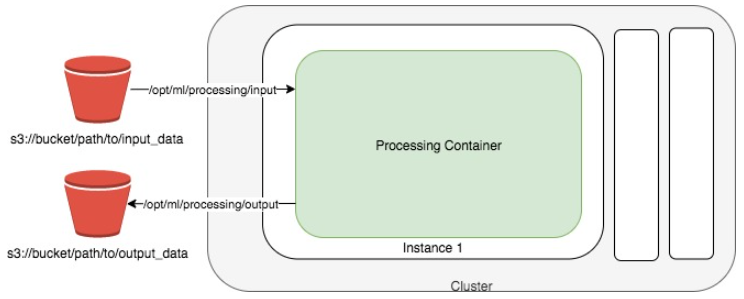

Here, we'll import the dataset and transform it with SageMaker Processing, which can be used to process terabytes of data in a SageMaker-managed cluster separate from the instance running your notebook server. In a typical SageMaker workflow, notebooks are only used for prototyping and can be run on relatively inexpensive and less powerful instances, while processing, training and model hosting tasks are run on separate, more powerful SageMaker-managed instances. SageMaker Processing includes off-the-shelf support for Scikit-learn, as well as a Bring Your Own Container option, so it can be used with many different data transformation technologies and tasks.

In [ ]:
df = pd.read_csv('./data-sample/bank-additional-full.csv')
pd.set_option('display.max_columns', 500)    
pd.set_option('display.max_rows', 20)        

In [ ]:
df

Upload this file to a path/prefix in s3 so training/processing jobs can find it!

In [ ]:
input_source = session.upload_data(
    './data-sample/bank-additional-full.csv', 
    bucket=working_bucket, 
    key_prefix=f'example-data/input_data'
)
print(f"This is where the data is going to go: {input_source}")

In [ ]:
%%writefile preprocessing.py
# cell 06


import pandas as pd
import numpy as np
import argparse
import os
from sklearn.preprocessing import OrdinalEncoder

def _parse_args():

    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    parser.add_argument('--categorical_features', type=str, default='y, job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome')

    return parser.parse_known_args()

if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    # Load data
    df = pd.read_csv(os.path.join(args.filepath, args.filename))
    # Change the value . into _
    df = df.replace(regex=r'\.', value='_')
    df = df.replace(regex=r'\_$', value='')
    # Add two new indicators
    df["no_previous_contact"] = (df["pdays"] == 999).astype(int)
    df["not_working"] = df["job"].isin(["student", "retired", "unemployed"]).astype(int)
    df = df.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
    # Encode the categorical features
    df = pd.get_dummies(df)
    # Train, test, validation split
    train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=42), [int(0.7 * len(df)), int(0.9 * len(df))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%
    # Local store
    pd.concat([train_data['y_yes'], train_data.drop(['y_yes','y_no'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    pd.concat([validation_data['y_yes'], validation_data.drop(['y_yes','y_no'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data['y_yes'].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop(['y_yes','y_no'], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    print("## Processing complete. Exiting.")


In [ ]:
prefix = "example-dataset"
train_path = f"s3://{working_bucket}/{prefix}/train"
validation_path = f"s3://{working_bucket}/{prefix}/validation"
test_path = f"s3://{working_bucket}/{prefix}/test"

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role

In [ ]:
sklearn_processor = SKLearnProcessor(
    framework_version="1.2-1",
    role=get_execution_role(),
    instance_type="ml.m5.large",
    instance_count=1, 
    base_job_name='xgboost-processing'
)

In [ ]:
sklearn_processor.run(
    code='code/preprocessing.py',
    # arguments = ['arg1', 'arg2'],
    inputs=[
        ProcessingInput(
            source=input_source, 
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data", 
            source="/opt/ml/processing/output/train",
            destination=train_path,
        ),
        ProcessingOutput(
            output_name="validation_data", 
            source="/opt/ml/processing/output/validation", 
            destination=validation_path
        ),
        ProcessingOutput(
            output_name="test_data", 
            source="/opt/ml/processing/output/test", 
            destination=test_path
        ),
    ]
)

Take a peak at the processed data. You will see that the First `0` column is the `y` while columns [1:] are all features `{x1...xn}` 

In [ ]:
pd.read_csv(
    os.path.join(train_path, "train.csv"), 
    index_col=False, 
    header=None
)

## Train a Model

In [ ]:
import mlflow
import tarfile
import xgboost as xgb

In [ ]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

print(f"Let's use a pretrained container that has a trainer built in with code and modules, all optimized: {container}")

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data=os.path.join(train_path, "train.csv"), 
    content_type='csv'
)
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data=os.path.join(validation_path, "validation.csv"), 
    content_type='csv'
)

In [ ]:
MLFLOW_TRACKING_SERVER_ARN = "arn:aws:sagemaker:us-east-1:122610505991:mlflow-tracking-server/demo-ml-cv-training"
MLFLOW_EXPERIMENT_NAME = "xgboost-model-training-v01"
RUN_NAME_PREFIX = "banking-classifier"

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_ARN)
experiment = mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

This is where you can change XGBoost training mode from Classification `'binary:logistic'` to Regression `'reg:linear'`

In [ ]:
with mlflow.start_run(
    run_name=f"{RUN_NAME_PREFIX}-{datetime.now().strftime('%y-%m-%d-%H-%M-%s')}",
    description="training in the notebook with a training job"
) as run:
    estimator = sagemaker.estimator.Estimator(
        container,
        role, 
        instance_count=1, 
        instance_type='ml.m4.xlarge',
        output_path=f"s3://{working_bucket}/training-jobs/output",
        sagemaker_session=session
    )
    # xgboost set HPs
    estimator.set_hyperparameters(
        max_depth=5,
        eta=0.2,
        gamma=4,
        min_child_weight=6,
        subsample=0.8,
        silent=0,
        objective='binary:logistic',
        num_round=100
    )
    training_inputs = {
        'train': s3_input_train, 
        'validation': s3_input_validation
    }
    mlflow.log_params(estimator.hyperparameters())
    
    estimator.fit(training_inputs)

    mlflow.log_param("training job name", estimator.latest_training_job.name)
    mlflow.log_metrics(
        {
            i['metric_name'].replace(':', '_'): i['value'] 
            for i in estimator.training_job_analytics.dataframe().iloc
        }
    )

## Register Model

Model Registration is an important component - allows you to track your Model as versioned artifacts - making it easier for deployment

In [ ]:
def get_or_create_model_package_group(sm_client, model_package_group_name, description):
    try:
        response = sm_client.describe_model_package_group(ModelPackageGroupName=model_package_group_name)
        print(f"ModelPackageGroup '{model_package_group_name}' already exists.")
    except botocore.exceptions.ClientError as error:
        if error.response['Error']['Code'] == 'ValidationException':
            response = sm_client.create_model_package_group(
                ModelPackageGroupName=model_package_group_name,
                ModelPackageGroupDescription=description
            )
            print(f"Created ModelPackageGroup '{model_package_group_name}'.")
        else:
            raise  # Reraise unexpected exceptions

    return response['ModelPackageGroupArn'], model_package_group_name

# Usage
model_package_group_arn, model_package_group_name = get_or_create_model_package_group(
    sm_client,
    model_package_group_name='example-xgboost-object-detection',
    description='A collection of versioned models for XGBoost for example data'
)

In [ ]:
estimator.register(
    content_types=['application/json'],
    response_types=['application/json'],
    inference_instances=['ml.m4.xlarge', 'ml.m5.xlarge'],
    transform_instances=['ml.m4.xlarge', 'ml.m5.xlarge'],
    model_package_group_name=model_package_group_name,
    domain="MACHINE_LEARNING",
    task="CLASSIFICATION",
    framework="XGBOOST",
    framework_version="1.7.1",
    nearest_model_name="xgboost-classifier"
)